# Temporal Clustering of Sentinel-2 Image Data of Lake Neusiedl
----
This notebook applies temporal clustering algorithms to raster images from Sentinel-2 of Lake Neusiedl. The goal is to identify classes (clusters) of the reed belt of the lake, based on randomly sampled points along its reed belt.

In [1]:
import glob
import os
import rasterio
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict

## Getting the Data
---
The data is split into two tiles, each of which contains one image per band and time step of the observation. The individual tiles are first merged on the basis of merging each corresponding pair of band-timestamp images. The procedure for merging tiles is available in the `merge_tiles.py` accompanying script. The variable `merged_path` now points to the directory where the results of the tile merging are stored.

In [2]:
merged_path = r"/home/e12331438/merged"
files_merged = glob.glob(os.path.join(merged_path, "*"))

In [3]:
files_merged = list(filter(lambda file_name: "B06" not in file_name, files_merged))

In [4]:
len(files_merged)

80

In [5]:
files_merged[0]

'/home/e12331438/merged/20190421_B02.tif'

## Data Preprocessing

### Shapefile with Randomly Sampled Points
-----
In this section the shapefile containing the randomly sampled points along the reed belt is loaded and preprocessed.

In [6]:
import geopandas as gpd

points = gpd.read_file("/home/e12331438/shared/datasets/rs/students/e12331438/shapefiles/sampling_points.shp")
points.head()

id          layer                                               path  \
0   0  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
1   1  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
2   2  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
3   3  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
4   4  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   

                    geometry  
0  POINT (16.75423 47.91376)  
1  POINT (16.77682 47.80841)  
2                       None  
3  POINT (16.70239 47.65050)  
4  POINT (16.72944 47.92613)

In [7]:
points.shape

(110, 4)

There are 14 rows in the loaded points' data, where the tuple describing the point coordinates is missing. Therefore, these lines are dropped.

In [8]:
len(points[points["geometry"].isna()])

14

In [9]:
points = points[~points["geometry"].isna()]

In [10]:
len(points)

96

#### Matching Coordinates
----
It is important to ensure that the sampling points as well as the raster images are in the same geoprojection before the sampling of the points from the raster images occurs.

In [11]:
with rasterio.open(files_merged[0]) as src:
    raster_crs = src.crs

In [12]:
raster_crs

CRS.from_wkt('PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [13]:
points.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The raster files containing each of the bands from Sentinel-2 are in a different (custom) coordinate system than the shapefile with the sampled points. To allow for sampling of the points from the raster images, the coordinate systems need to be matching. In this case, the re-projection of the sampled points into the custom coordinate system of the raster images is performed. 

In [14]:
points_projected = points.to_crs(raster_crs)
coords = list(zip(points_projected.geometry.x, points_projected.geometry.y)) 

#### Sampling Points
----
Once the data from the images as well as the points are in the same geoprojections, the sampling of the points from the raster is applied.

In [15]:
def get_sample_values(band_path:str, coords:List[Tuple[float, float]]) -> List[float]:
    """
    Extracts the values of the pixels at given coordinates
    from the specified raster image.

    Args:
        band_path (str): Path to the raster image with the band values.
        coords (List[Tuple[int, int]]): List of coordinates of sampling points. 

    Returns:
        List[float]: The extracted timestamp.
    """
    with rasterio.open(band_path) as src:
        return [val[0] for val in src.sample(coords)]


def sample_points(file_names:List[str], band_names:List[str], coords:List[Tuple[float, float]]) -> Dict[str, List[float]]:
    """
    Extracts the values of the pixels at given coordinates
    from the specified raster image.

    Args:
        file_names (List[str]): List of file paths to the raster images with the band values.
        band_names (List[str]): List of band names to extract values from e.g. "B08".
        coords (List[Tuple[int, int]]): List of coordinates of sampling points. 

    Returns:
         Dict[str, List[float]]: Dictionary, where the band name is the key, 
         and the value is a list of the extracted values of the band.
    """
    sampled_points = {}
    
    for f_name in sorted(file_names):
        [year, band] = f_name.split("/")[-1].replace(".tif", "").split("_") 
        if band not in band_names:
            continue
        sampled_points[band] = sampled_points.get(band, {})
        sampled_points[band][year] = get_sample_values(f_name, coords)
    return sampled_points

In [16]:
sampled = sample_points(files_merged, ["B08"], coords)

In [17]:
band08 = pd.DataFrame(sampled['B08'], points_projected.index)

The retrieved time series has an entry (row) per each of the sampled points, and one column per each of the timesteps at which the value was recorded.

In [18]:
band08

20190121  20190421  20190809  20191114  20200215  20200721  20200909  \
0         985       981      2263      1342      1002      2026      2082   
1         769       807      1965      1422       830      1938      2142   
3        1095      1209      2380      2199      1192      2206      2742   
4        1760      2748      3174      2257      1732      3640      3858   
6        1339      1624      3536       582      1278      3606      3662   
..        ...       ...       ...       ...       ...       ...       ...   
105      1192      1359      3685      1664      1222      2896      2624   
106       908      1067      2610      1324       890      2370      2554   
107       824       919      1630      2530       760      1520      1602   
108       629       777      2044      2454       689      1946      1868   
109       922       999      2624      1588       947      2276      2702   

     20201121  20210226  20210616  20211004  20211123  20220214  20220515  \
0        1548      1150      1810      2176      1050      1136      1562   
1        1206       894      2014      2156      1256      1220      1750   
3        1414      1220      1846      2030      1084      1408      1678   
4        1870      1794      4292      3108      1696      1746      3404   
6        1694      1340      3232      2824      1604      1766      2618   
..        ...       ...       ...       ...       ...       ...       ...   
105      1444      1206      2476      2484      1342      1268      1648   
106      1462      1092      2850      3066      1620      2150      2342   
107      1176       989      1480      1866      1104      1174      1412   
108      1102       741      1534      1642       927       980      1344   
109      1240       894      2470      2648      1438      1294      1744   

     20220721  20221218  
0        2454      1422  
1        2520       886  
3        2470      1682  
4        3516      1572  
6        4084      6924  
..        ...       ...  
105      2840      1294  
106      3712      3804  
107      1902      1118  
108      2074       962  
109      3028      1130  

[96 rows x 16 columns]

### Missing Values
---
The raster images define a symbolic value that indicates no actual value was recorded at that pixel. This section explores the missing values in the sampled dataset of band 8.

In [19]:
with rasterio.open(files_merged[0]) as src:
    raster_metadata = src.meta
raster_metadata["nodata"]

65535.0

In [20]:
def find_nans(df:pd.DataFrame, nan_value:float) -> pd.DataFrame:
    """
    Find the NaNs defined by a unique value in a data frame.

    Args:
        df (DataFrame): Data frame of band values.
        nan_value (float): Unique value considered as NaN. 

    Returns:
        DataFrame: The subset rows of the data frame containing NaNs.
    """
    nans = df.index[df[df == nan_value].any(axis="columns")]
    return df.loc[nans]

In [21]:
band08_nans = find_nans(band08, raster_metadata["nodata"])
band08_nans

20190121  20190421  20190809  20191114  20200215  20200721  20200909  \
8       1082      1344      3385     65535     65535      2680      2872   
30     65535     65535     65535     65535     65535     65535     65535   
49      2033      3430      2708     65535     65535      3626      3482   
63     65535     65535     65535     65535     65535     65535     65535   
79     65535     65535     65535     65535     65535     65535     65535   

    20201121  20210226  20210616  20211004  20211123  20220214  20220515  \
8       1009       848      3034     65535     65535      1346      1840   
30     65535     65535     65535     65535     65535     65535     65535   
49      2954      2670      3002     65535     65535      2148      4420   
63     65535     65535     65535     65535     65535     65535     65535   
79     65535     65535     65535     65535     65535     65535     65535   

    20220721  20221218  
8       3392     65535  
30     65535     65535  
49      2886     65535  
63     65535     65535  
79     65535     65535

There are three points where all the columns have no values, and two points where at least some of the values are missing. Upon inspecting the coordinates of these points, it is apparent that they do not belong to the reed belt of the Lake Neusiedl. Therefore, these  points are excluded from further experiments.

In [22]:
points.loc[band08_nans.index]

id          layer                                               path  \
8    8  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
30   5  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
49  24  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
63   0  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
79  16  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   

                     geometry  
8   POINT (16.25651 47.92043)  
30  POINT (13.26247 46.72127)  
49  POINT (16.24135 47.90848)  
63  POINT (14.61571 46.55642)  
79  POINT (13.08386 47.98855)

In [23]:
points_clean = points_projected.drop(band08_nans.index)
len(points_clean)

91

In [24]:
coords_clean = list(zip(points_clean.geometry.x, points_clean.geometry.y))

In [25]:
bands_sampled = ["B02", "B04", "B08", "B11"]
sampled_points = sample_points(files_merged, bands_sampled, coords_clean)

Scaling the values to be in the [0, 1] range instead of [0, 65535] to ensure the correct calculation of the indices.

In [26]:
band02 = pd.DataFrame(sampled_points['B02'], points_clean.index).astype(np.float64) / raster_metadata["nodata"]
band04 = pd.DataFrame(sampled_points['B04'], points_clean.index).astype(np.float64) / raster_metadata["nodata"]
band08 = pd.DataFrame(sampled_points['B08'], points_clean.index).astype(np.float64) / raster_metadata["nodata"]
band11 = pd.DataFrame(sampled_points['B11'], points_clean.index).astype(np.float64) / raster_metadata["nodata"]

Final check to verify no data is missing and ensure consistency across all bands. The `nodata` value now after scaling would be `1.0`.

In [27]:
for band in [band02, band04, band08, band11]:
    assert len(find_nans(band11, 1.0)) == 0

### Retrieving Indices
---
As a final step, the raw band values are used as inputs to retrieve indices. The indices will be used instead of the raw values of the bands as inputs to the clustering algorithms. The formulas for each of the indices are implemented in `index_calculation.py` script.

In [28]:
from index_calculation import ndmi, ndvi, evi

In [29]:
assert (band08.columns == band11.columns).all()
df_ndmi = ndmi(band08, band11)
assert df_ndmi.min().min() >= -1
assert df_ndmi.max().max() <= 1
df_ndmi

20190121  20190421  20190809  20191114  20200215  20200721  20200909  \
0   -0.188633 -0.257943  0.106872 -0.132515 -0.303441 -0.041854 -0.010456   
1   -0.099532 -0.092749  0.138470 -0.077522 -0.212150  0.027572  0.080454   
3   -0.030544 -0.106430  0.211504  0.035067 -0.189942  0.107986  0.161126   
4   -0.110212  0.020423  0.141727  0.019652 -0.206051  0.179329  0.346362   
6   -0.091896 -0.154167  0.295713  0.048649 -0.232893  0.322575  0.273075   
..        ...       ...       ...       ...       ...       ...       ...   
105 -0.194050 -0.220533  0.296622 -0.149067 -0.253740  0.168213  0.102753   
106 -0.128181 -0.240299  0.195876 -0.156688 -0.299488  0.101557  0.124367   
107 -0.149200 -0.200174  0.015260  0.079812 -0.301471 -0.102451 -0.058201   
108 -0.238959 -0.154056  0.127413  0.061648 -0.294780  0.037590  0.004841   
109 -0.209940 -0.188465  0.185185 -0.136017 -0.302908  0.079184  0.123960   

     20201121  20210226  20210616  20211004  20211123  20220214  20220515  \
0   -0.254874 -0.287264 -0.102183  0.016110 -0.308072 -0.295941 -0.252095   
1   -0.168563 -0.203918  0.171271  0.062069 -0.149340 -0.164956 -0.072110   
3   -0.195219 -0.220696 -0.016254 -0.005390 -0.173150 -0.170301 -0.188588   
4   -0.046891 -0.111441  0.432816  0.254237 -0.093048 -0.175053  0.205596   
6   -0.103229 -0.094900  0.297471  0.136647 -0.092247 -0.123791  0.000191   
..        ...       ...       ...       ...       ...       ...       ...   
105 -0.255286 -0.241032  0.120616  0.032419 -0.209426 -0.210215 -0.202323   
106 -0.225225 -0.255877  0.115460  0.181048 -0.093453 -0.146487 -0.150988   
107 -0.235619 -0.238059 -0.128643 -0.007711 -0.217576 -0.242581 -0.259764   
108 -0.233924 -0.306504 -0.021059 -0.077269 -0.263116 -0.263988 -0.234188   
109 -0.245283 -0.319376  0.148837  0.090161 -0.123171 -0.204427 -0.145308   

     20220721  20221218  
0    0.068583 -0.003853  
1    0.122244 -0.194179  
3    0.107872 -0.076078  
4    0.064004 -0.063728  
6    0.365201 -0.014167  
..        ...       ...  
105  0.156587 -0.121521  
106  0.285096 -0.072986  
107 -0.060277 -0.163487  
108  0.011214 -0.211798  
109  0.193065 -0.147813  

[91 rows x 16 columns]

In [30]:
assert (band08.columns == band04.columns).all()
df_ndvi = ndvi(band08, band04)
assert df_ndvi.min().min() >= -1
assert df_ndvi.max().max() <= 1
df_ndvi

20190121  20190421  20190809  20191114  20200215  20200721  20200909  \
0    0.253978  0.241772  0.713745  0.266038  0.278061  0.504642  0.574291   
1    0.154655  0.139831  0.596912  0.233304  0.195965  0.500581  0.613559   
3    0.246443  0.307734  0.759054  0.158893  0.283100  0.609632  0.714286   
4    0.260745  0.390336  0.537791  0.464633  0.242468  0.586748  0.776652   
6    0.237523  0.283287  0.807771  0.366197  0.254171  0.783824  0.761847   
..        ...       ...       ...       ...       ...       ...       ...   
105  0.210767  0.217742  0.814377  0.253956  0.240609  0.688630  0.655521   
106  0.166346  0.232813  0.757576  0.232201  0.257062  0.656184  0.679158   
107  0.195069  0.234385  0.631632  0.047402  0.275168  0.408059  0.509185   
108  0.210780  0.220738  0.709745  0.046928  0.281860  0.575071  0.562526   
109  0.230153  0.208711  0.739476  0.246468  0.221148  0.631541  0.689278   

     20201121  20210226  20210616  20211004  20211123  20220214  20220515  \
0    0.211742  0.210526  0.451484  0.577383  0.244813  0.185804  0.240667   
1    0.284345  0.176316  0.659662  0.583548  0.306292  0.212724  0.354489   
3    0.303226  0.209118  0.497161  0.543726  0.338272  0.269612  0.240207   
4    0.484716  0.293906  0.855599  0.752467  0.447717  0.261561  0.712274   
6    0.329149  0.223744  0.730193  0.586963  0.358171  0.259629  0.450416   
..        ...       ...       ...       ...       ...       ...       ...   
105  0.248595  0.213280  0.653975  0.568677  0.310547  0.231068  0.261868   
106  0.229088  0.209972  0.540957  0.658194  0.287758  0.168478  0.212215   
107  0.211747  0.206833  0.418984  0.514610  0.274827  0.190669  0.209940   
108  0.271050  0.193237  0.490044  0.452455  0.227002  0.182147  0.215190   
109  0.282316  0.184891  0.710526  0.658109  0.361098  0.218456  0.375394   

     20220721  20221218  
0    0.621943  0.185988  
1    0.607143  0.207907  
3    0.605460  0.211816  
4    0.491094  0.348199  
6    0.789658  0.028215  
..        ...       ...  
105  0.674035  0.221907  
106  0.763839  0.085616  
107  0.447489  0.221191  
108  0.530627  0.122520  
109  0.712670  0.237678  

[91 rows x 16 columns]

In [31]:
assert (band04.columns == band02.columns).all()
df_evi = evi(band08, band04, band02)
assert df_evi.min().min() >= -1
assert df_evi.max().max() <= 1
df_evi

20190121  20190421  20190809  20191114  20200215  20200721  20200909  \
0    0.014728  0.014256  0.069543  0.020575  0.016164  0.050469  0.056079   
1    0.007584  0.007365  0.054066  0.019625  0.009937  0.048068  0.059703   
3    0.015997  0.021064  0.075678  0.022656  0.019287  0.061881  0.083505   
4    0.026154  0.055404  0.079798  0.051947  0.024374  0.096015  0.121217   
6    0.018462  0.026100  0.115014  0.011532  0.018853  0.115872  0.114569   
..        ...       ...       ...       ...       ...       ...       ...   
105  0.015132  0.017888  0.120248  0.024226  0.017275  0.087072  0.076003   
106  0.009497  0.014927  0.082910  0.018255  0.013396  0.069745  0.075736   
107  0.009975  0.013056  0.046951  0.008978  0.012185  0.032975  0.040178   
108  0.008129  0.010556  0.063117  0.008473  0.011353  0.053152  0.049818   
109  0.012601  0.012839  0.082107  0.022493  0.012568  0.065407  0.080576   

     20201121  20210226  20210616  20211004  20211123  20220214  20220515  \
0    0.019795  0.014760  0.041581  0.058451  0.015224  0.013093  0.022340   
1    0.019542  0.009827  0.058891  0.057691  0.021478  0.015569  0.033386   
3    0.023905  0.015375  0.045201  0.052131  0.020257  0.021879  0.023617   
4    0.044571  0.029317  0.142423  0.097182  0.038108  0.025971  0.102348   
6    0.030033  0.017700  0.099271  0.075365  0.030456  0.026144  0.058514   
..        ...       ...       ...       ...       ...       ...       ...   
105  0.020753  0.015464  0.072138  0.065179  0.023104  0.017355  0.024872   
106  0.019675  0.013932  0.072388  0.087585  0.025881  0.021975  0.029259   
107  0.015172  0.012507  0.032431  0.046646  0.017568  0.013924  0.018072   
108  0.017504  0.008916  0.037585  0.037804  0.012792  0.011225  0.017646   
109  0.019972  0.010214  0.075291  0.076410  0.027601  0.016992  0.034681   

     20220721  20221218  
0    0.069620  0.016764  
1    0.069356  0.011323  
3    0.068513  0.021989  
4    0.082278  0.030523  
6    0.130743  0.014619  
..        ...       ...  
105  0.084086  0.017619  
106  0.117051  0.021919  
107  0.043558  0.015219  
108  0.053240  0.008041  
109  0.092154  0.016118  

[91 rows x 16 columns]

## Temporal Clustering
---
Finally, the clustering is performed for each of the three extracted indices using multiple clustering algorithms/implementations to compare the obtained results across them. 

In [62]:
import matplotlib.pyplot as plt

def plot_result(model, X:np.array, cols) -> None:
    """
    Plots the resulting clusters of the model applied to
    the input features.

    Args:
        model: Instance of a clustering model fitted on the data.
        X (array): Input data for the clustering model. 

    This code was adapted from the tslearn project.
    Copyright (c) 2017, Romain Tavenard
    Distributed under the BSD 3-Clause License.
    Source: https://github.com/tslearn-team/tslearn/blob/5568c026db4b4380b99095827e0573a8f55a81f0/docs/examples/clustering/plot_kmeans.py#L4
    """
    n_clusters = model.cluster_centers_.shape[0]
    plt.figure(figsize=(16, 9))
    y_pred = model.labels_
    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, 1 + yi)
        for xx in X[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.xticks(range(0, len(cols)), cols)
        plt.plot(model.cluster_centers_[yi].ravel(), "r-")
        plt.title("Cluster %d (%d points)" % (yi + 1, len(X[y_pred == yi])))
    plt.savefig("bar.png", bbox_inches='tight')
    plt.tight_layout()
    plt.show()

In [33]:
from sklearn.metrics import silhouette_score 
# used to collect performance metrics from all applied models
metrics = {
    "model_name": [],
    "index": [],
    "n_clusters": [],
    "inertia": [],
    "silhouette_score": []
}

def save_metrics(model_name, index, model, X):
    """
    Calculate the performance metrics of the model
    and store them to the dictionary.
    """
    metrics['model_name'].append(model_name)
    metrics["index"].append(index)
    metrics["n_clusters"].append(model.cluster_centers_.shape[0])
    metrics["inertia"].append(model.inertia_)
    metrics["silhouette_score"].append(silhouette_score(X, model.labels_))

In [63]:
def run_model(model, model_name, index, df, params):
    """
    Wrapper to run the model including plotting the results
    and saving the metrics.
    """
    model.set_params(**params).fit(df)
    X = model['scaler'].transform(df) 
    plot_result(model['model'], X, list(df.columns))
    save_metrics(model_name, index, model['model'], X.reshape(df.shape))

### K-Means from scikit-learn

In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [36]:
kmeans_scikit = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('model', KMeans(random_state=1111))])

#### NDMI
----
When clustering the NDMI values into 3 clusters the resulting clusters are relatively equally dense. When another cluster is added, the clusters have now a bit more notable difference in density.

Interpretation of the clusters:
- Cluster 1 - big range of values that change quite dramatically with time, typically low at the start of the year and reaching a peak around summer which best describes reed that is older
- Cluster 2 - values reach the biggest values among the three clusters, meaning substantial water content is detected, the values drop slightly around the beginning of the year and peak in summer, which corresponds to healthy reed, it might be young reed since the values are very high for the water content
- Cluster 3 - appear very similar to Cluster 1, following the same pattern in time, hence also appears to older reed

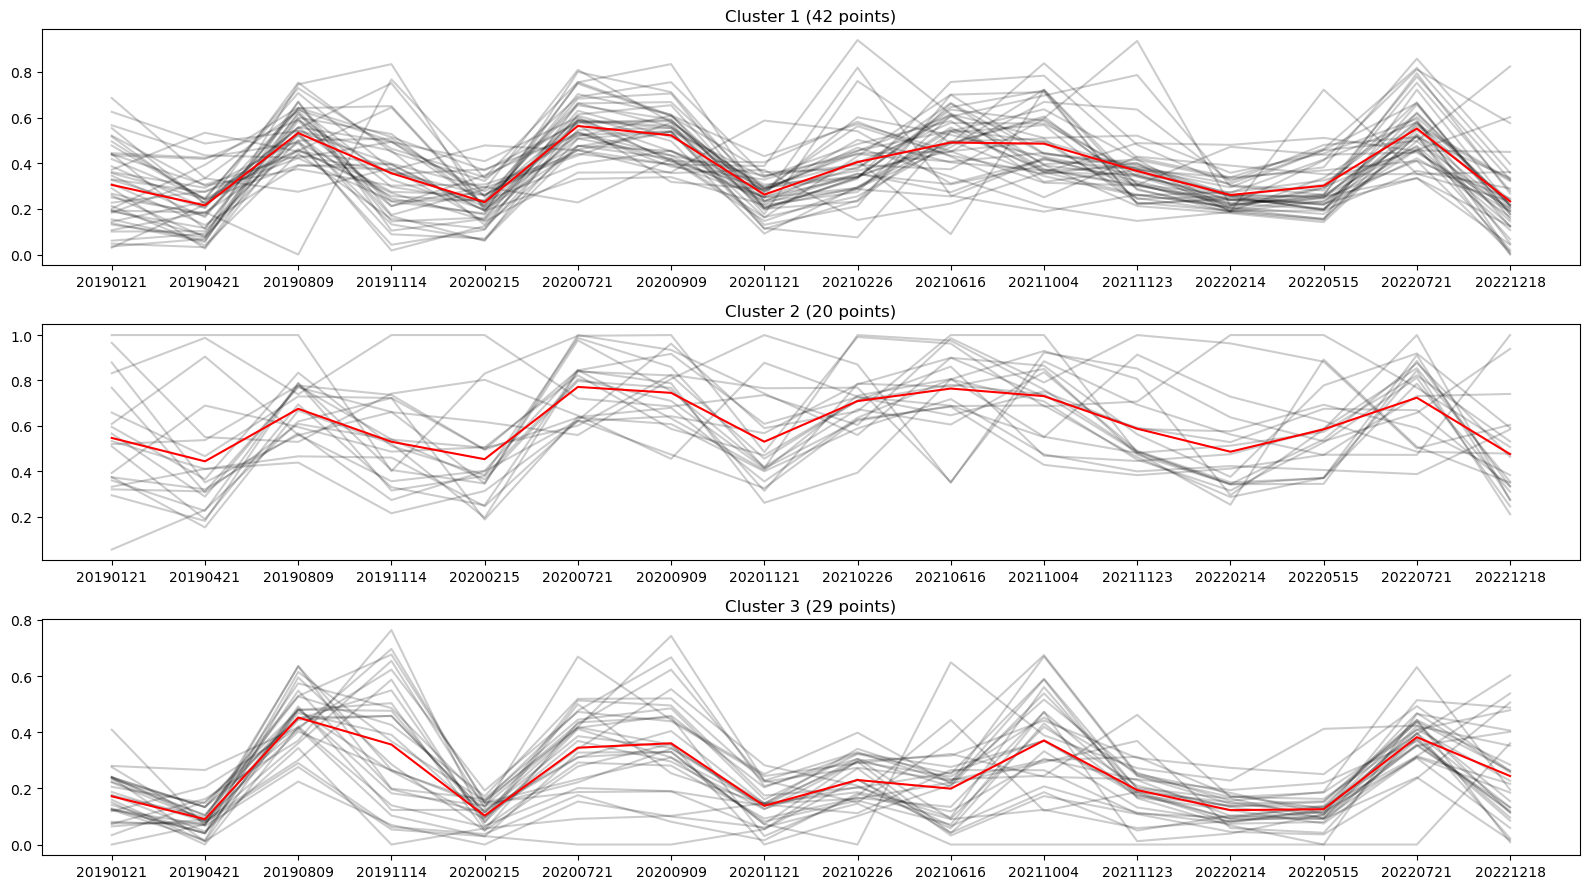

In [37]:
run_model(kmeans_scikit, "kmeans_scikit", "NDMI", df_ndmi, {"model__n_clusters": 3})

Interpretation of the clusters:
- Cluster 1 - peak occur off-season, and get more muted or disappear all together as time goes on - broken reed
- Cluster 2 - clear seasonal pattern - peaks in spring/summer, dips in autumn/winter, very high values - young reed
- Cluster 3 - lowest values among the clusters, erratic behavior - inundated reed
- Cluster 4 - clear seasonal pattern, values not as high - old reed

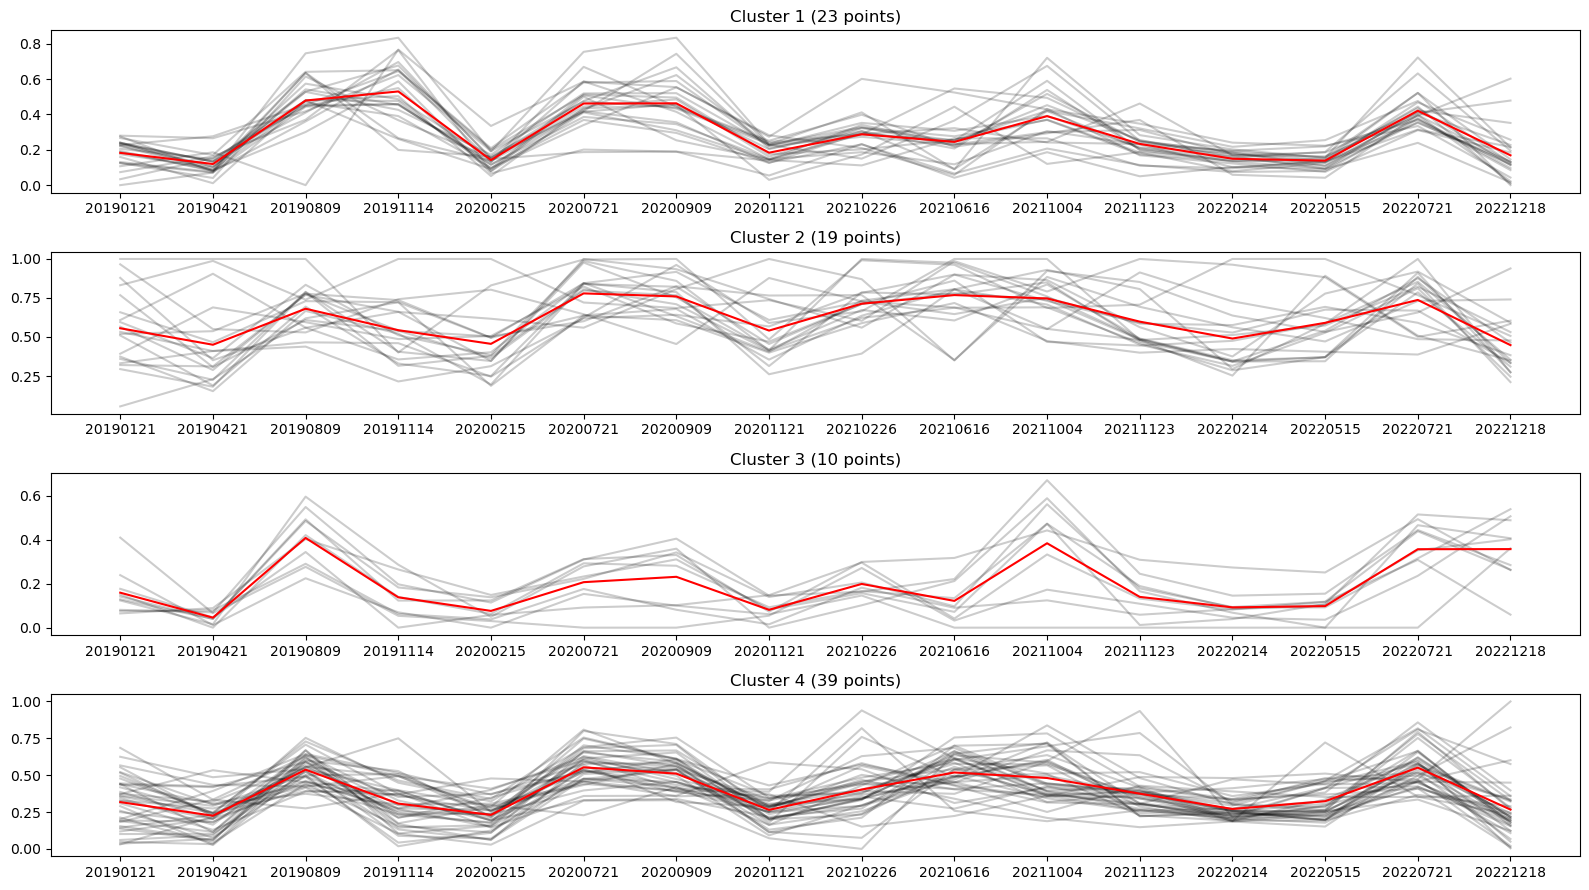

In [38]:
run_model(kmeans_scikit, "kmeans_scikit", "NDMI", df_ndmi, {"model__n_clusters": 4})

#### NDVI
----
With the NDVI there is one cluster with significantly more points compared to the other when the cluster counts is set to 3. When the cluster count is increased to 4, there are now two clusters which are half the size of the other two clusters. The patterns across the clusters vary significantly from the ones observed in the NDMI.

Interpretation of the clusters:
- Cluster 1 - lowest values, erratic behavior - inundated or broken reed
- Cluster 2 - clear seasonal pattern - peaks in spring/summer, dips in autumn/winter, very high values - young reed
- Cluster 3 - clear seasonal pattern, values slightly lower especially as time increases the peaks get smaller - old reed

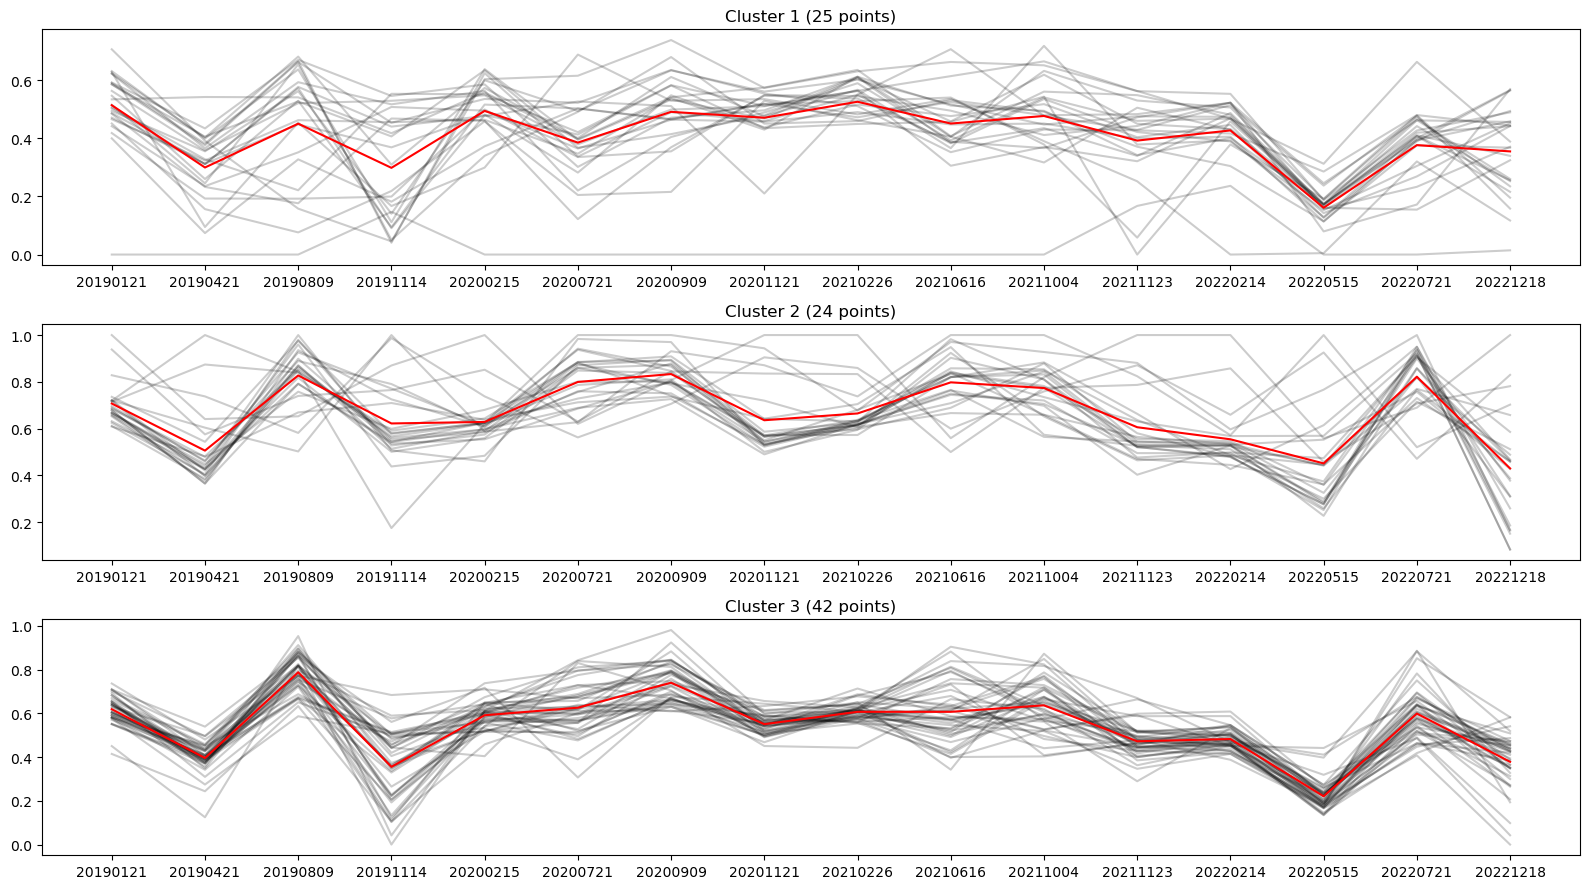

In [39]:
run_model(kmeans_scikit, "kmeans_scikit", "NDVI", df_ndvi, {"model__n_clusters": 3})

Interpretation of the clusters:
- Cluster 1 - clear seasonal pattern, values slightly lower especially as time increases the peaks get smaller - old reed
- Cluster 2 - clear seasonal pattern - peaks in spring/summer, dips in autumn/winter, very high values - young reed
- Cluster 3 - similar to cluster 1, but more noise and erratic behavior especially as time goes on the seasonality is less consistent - broken reed
- Cluster 4 - lowest values, erratic behavior, mainly just flat-lining - inundated

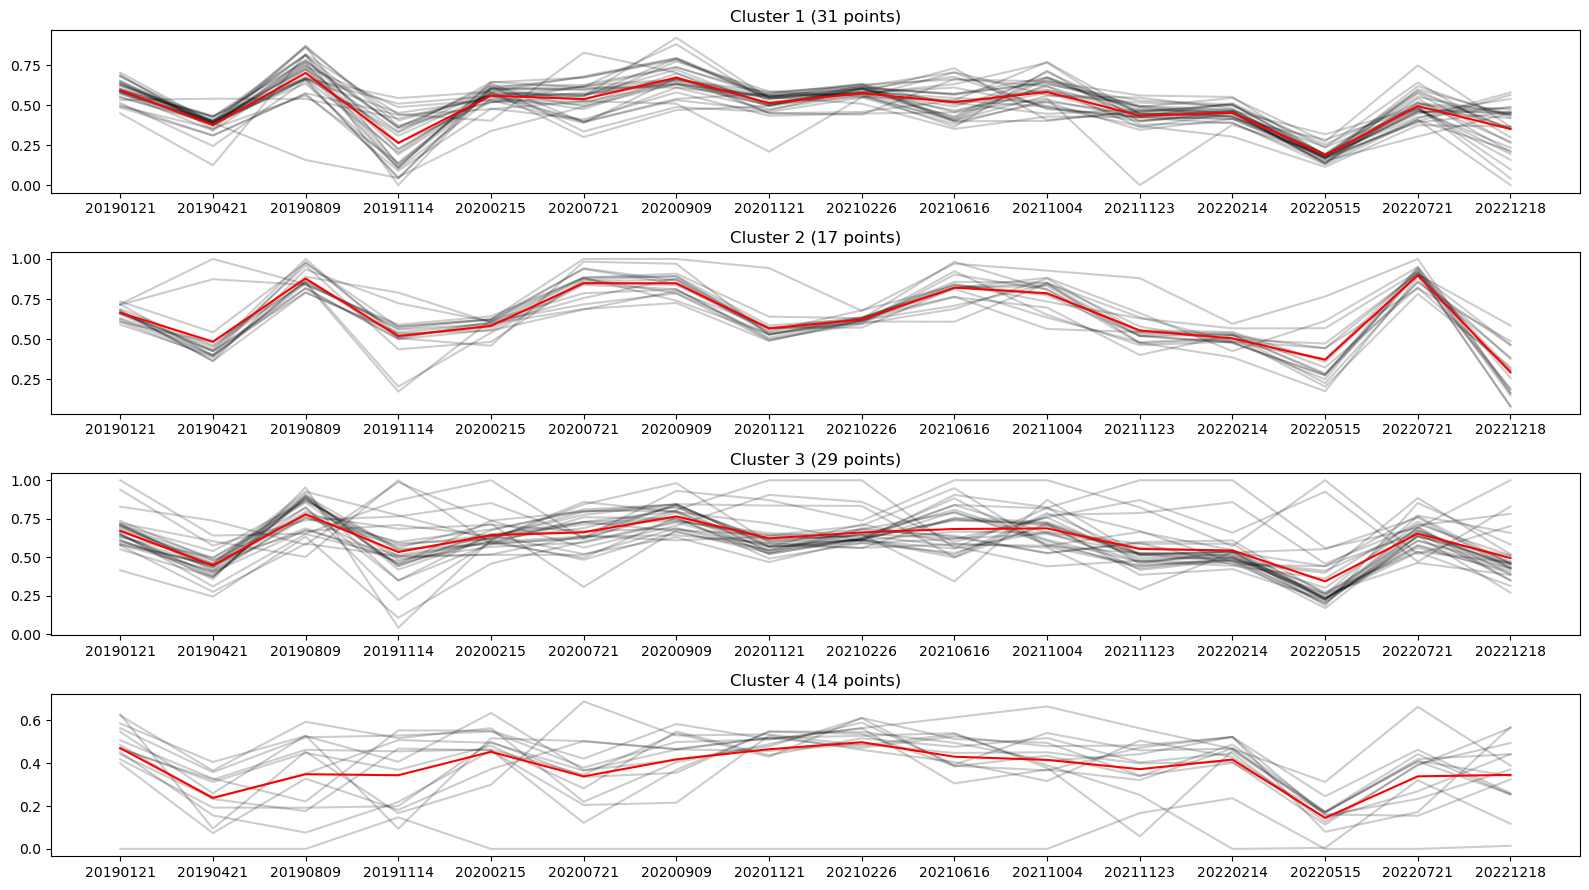

In [40]:
run_model(kmeans_scikit, "kmeans_scikit", "NDVI", df_ndvi, {"model__n_clusters": 4})

#### EVI
----
With the EVI there is always one cluster significantly smaller than the rest. The resulting shapes of the time series across the clusters are similar to the NDVI.

Interpretation of the clusters:
- Cluster 1 - clear seasonal pattern slightly diminishing with time, values slightly lower especially as time increases the peaks get smaller - old reed
- Cluster 2 - erratic behavior, no seasonal consistency - broken reed
- Cluster 3 - clear seasonal pattern - peaks in spring/summer, dips in autumn/winter, very high values - young reed

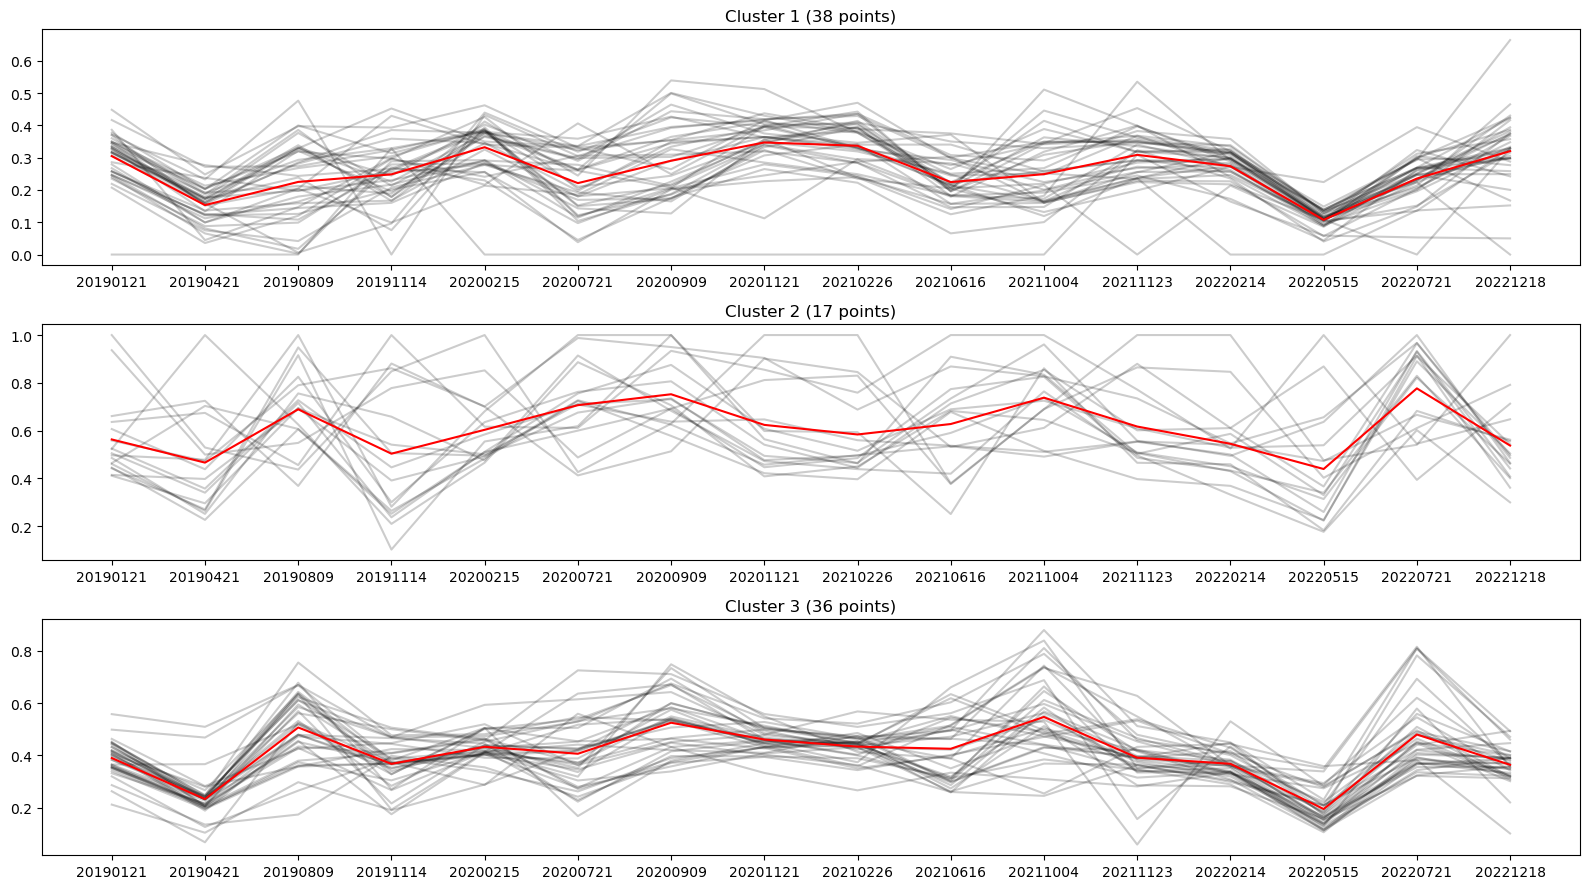

In [41]:
run_model(kmeans_scikit, "kmeans_scikit", "EVI", df_evi, {"model__n_clusters": 3})

Interpretation of the clusters:
- Cluster 1 - clear seasonal pattern, values slightly lower especially as time increases the peaks get smaller - old reed
- Cluster 2 - a lot of noise, not clear what the characteristics are - might be broken reed
- Cluster 3 - similar to cluster 1, but the peaks are slightly bigger and higher values are reached - young reed
- Cluster 4 - lowest values, erratic behavior, peak off-season maybe flooding - inundated

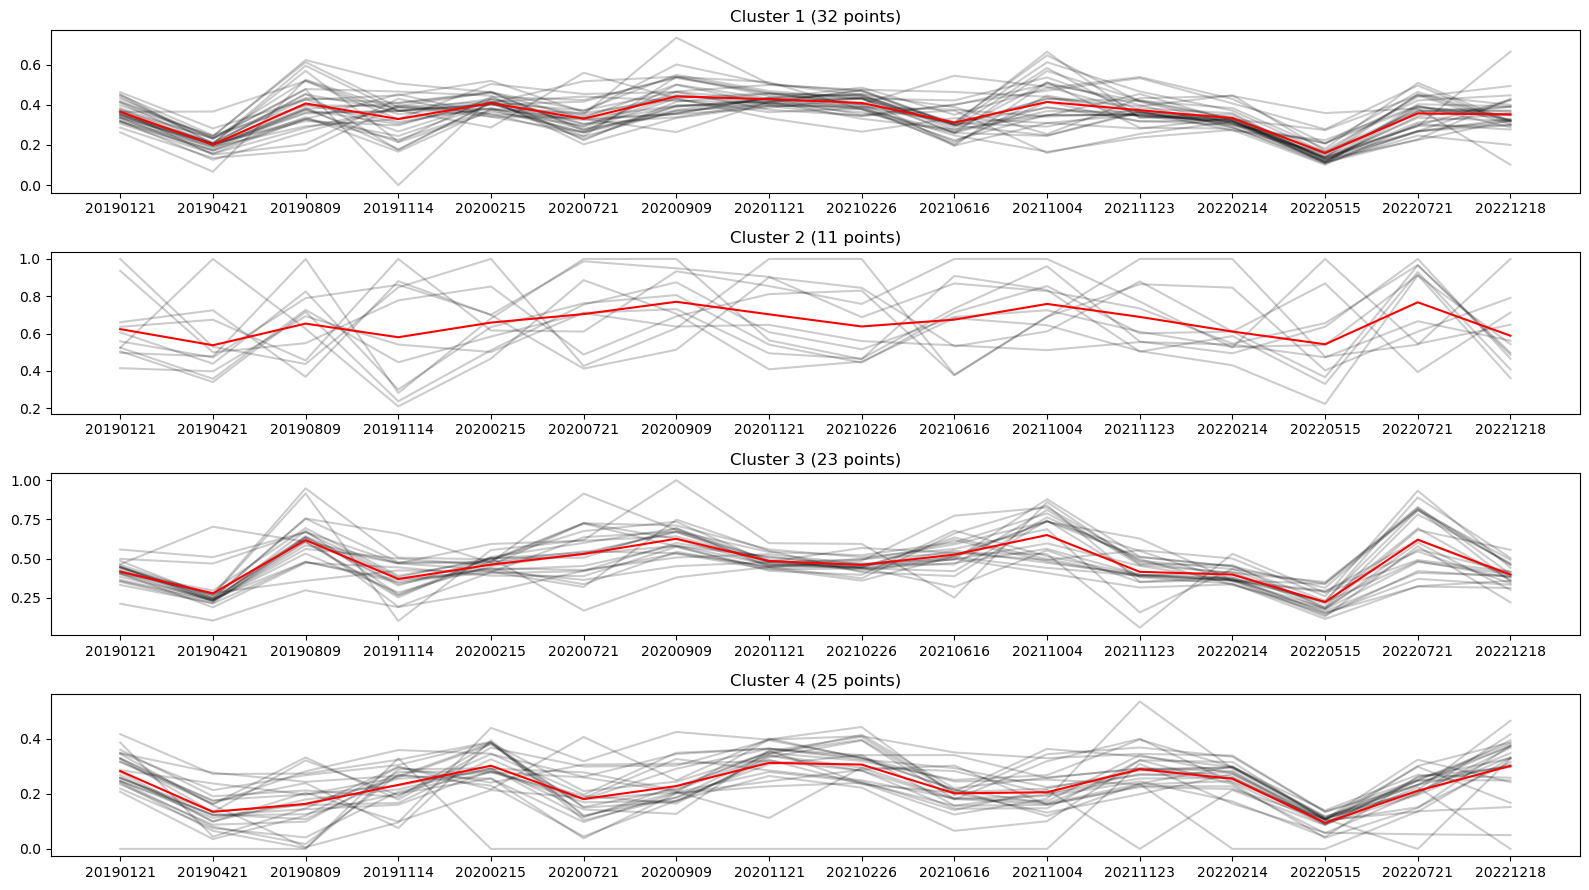

In [42]:
run_model(kmeans_scikit, "kmeans_scikit", "EVI", df_evi, {"model__n_clusters": 4})

#### K-Means from tslearn

In [43]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
kmeans_tslearn = Pipeline(steps=[
    ('scaler', TimeSeriesScalerMeanVariance()),
    ('model', TimeSeriesKMeans(metric="softdtw", random_state=1111))])

#### NDMI
----
This clustering algorithm offers similar results to the previous implementation for the NDMI, but produces very similar looking clusters with no key characteristics per cluster standing out, which leads to very challenging interpretation and is not very useful.

The clusters appear very similar, and it is challenging to determine and reason as to what their unique characteristics are in comparison to one another. All three show seasonal patterns, but Cluster 2 and Cluster 3 do it more consistently, hence these would represent the healthy reed. Cluster 2 could represent young reed, whereas cluster 3 could capture old reed since the values in 2 are higher with bigger peaks than in 3 which is most likely the characteristic of younger reed. Cluster 1 is still pretty consistent seasonally, perhaps only towards the end of the time-series it becomes more flat, hence it could still be young or old healthy reed.

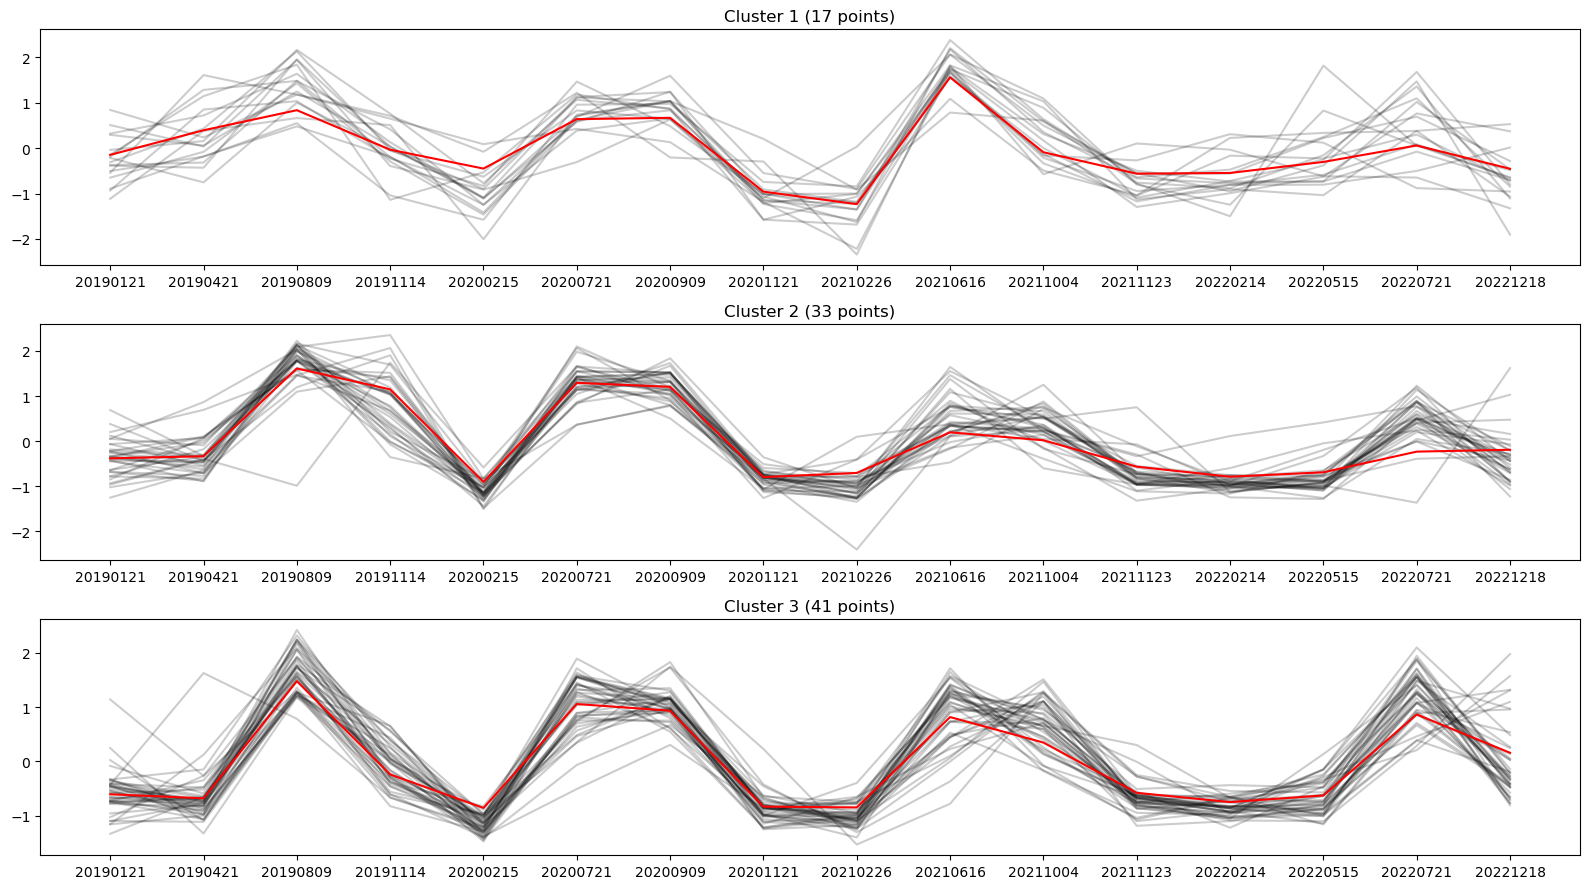

In [44]:
run_model(kmeans_tslearn, "kmeans_tslearn", "NDMI", df_ndmi, {"model__n_clusters": 3})

Similarly to the previous case, the clusters appear very similar, and it is challenging to find key characteristic to tell them apart.

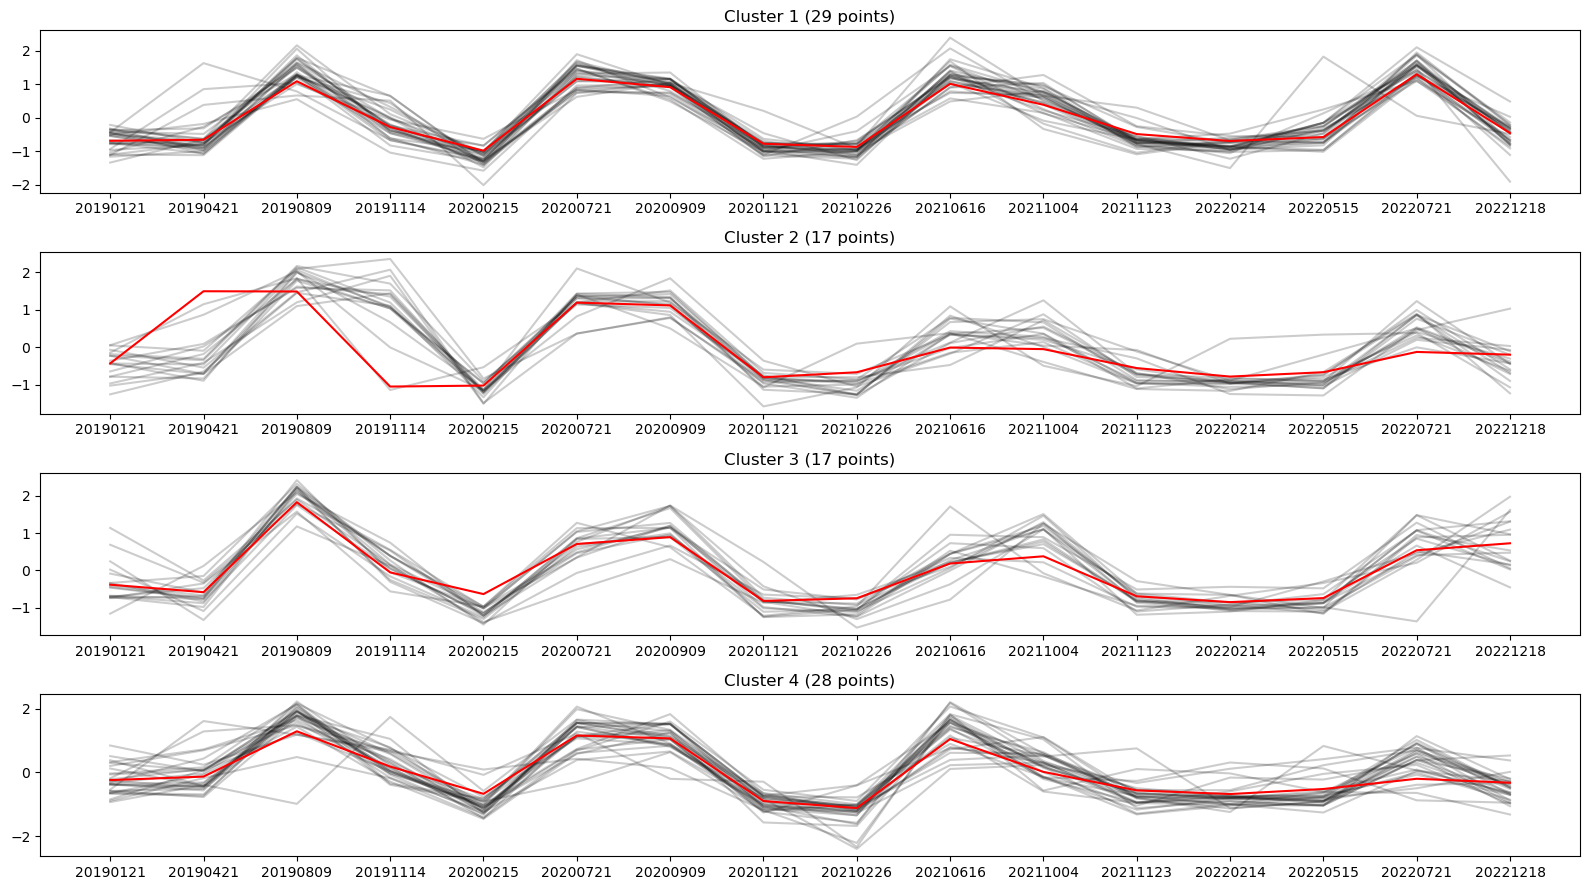

In [45]:
run_model(kmeans_tslearn, "kmeans_tslearn", "NDMI", df_ndmi, {"model__n_clusters": 4})

#### NDVI
----
For the NDVI we experience the homogeneity among the clusters again. 

Again the overall shapes appear very similar to each other.
Interpretation of the clusters:
- Cluster 1 - apparent seasonal pattern in the first half but erratic behavior in the second half - might be broken reed
- Cluster 2 - clear seasonal trend, big peaks - young reed
- Cluster 3 - clear seasonal pattern - peaks in spring/summer, dips in autumn/winter, slightly lower values - old reed

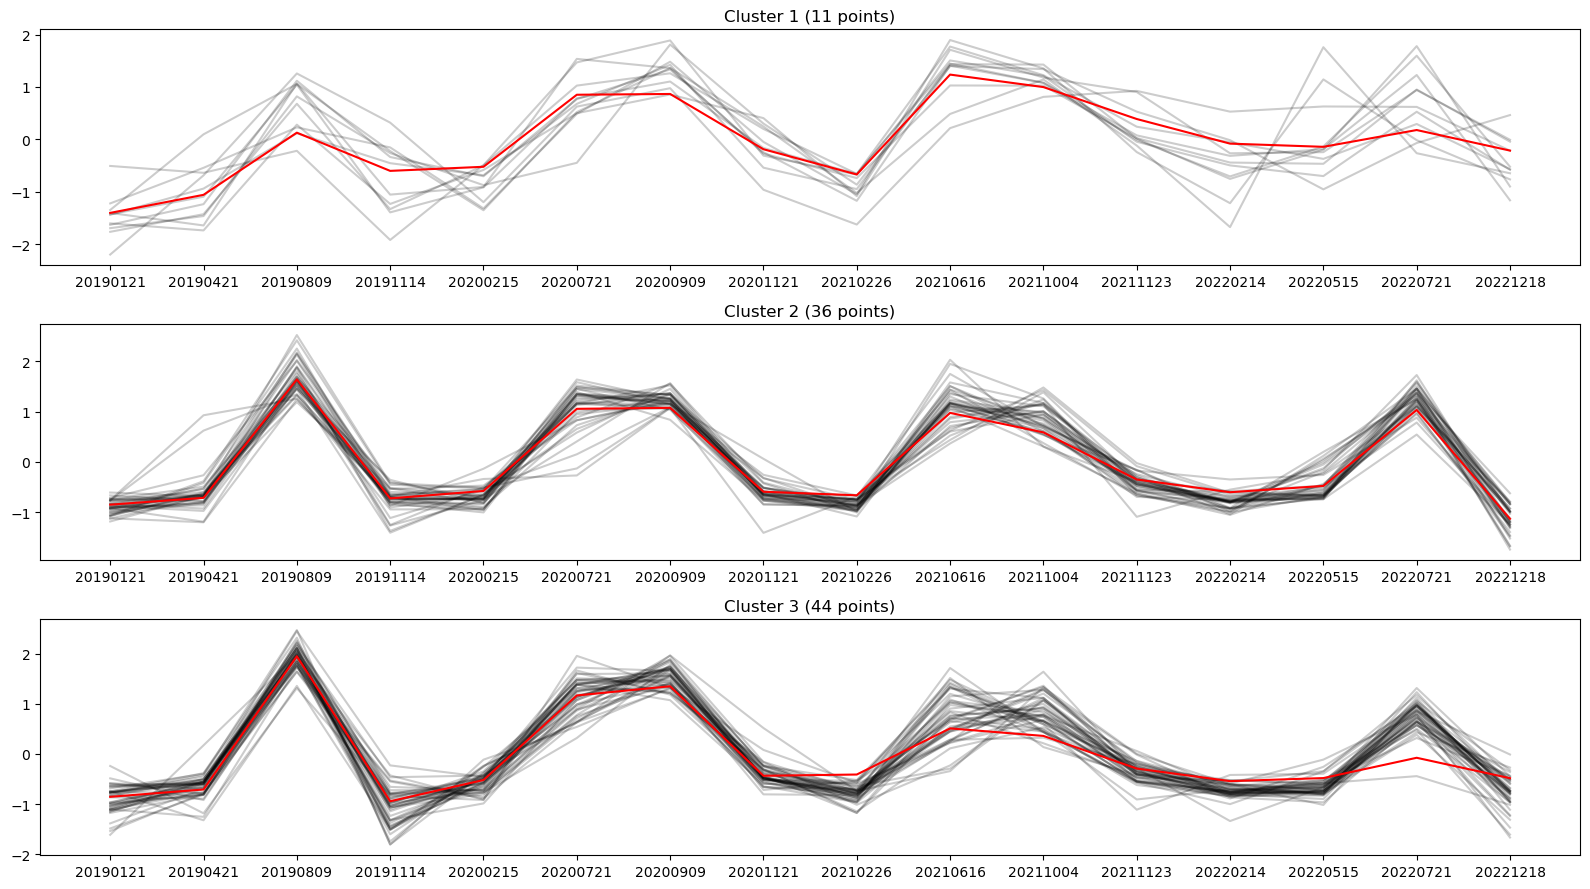

In [46]:
run_model(kmeans_tslearn, "kmeans_tslearn", "NDVI", df_ndvi,{"model__n_clusters": 3})

Interpretation of the clusters:
- Cluster 1 - apparent seasonal pattern, but very low values, might indicate seasonal flooding - inundated reed
- Cluster 2 - clear seasonal pattern - peaks in spring/summer, dips in autumn/winter, very high values - young reed
- Cluster 3 - erratic behavior, seasonal pattern tends to fall apart as time goes on - broken reed
- Cluster 4 - clear seasonal trend, values slightly lower especially as time increases the peaks get smaller - old reed

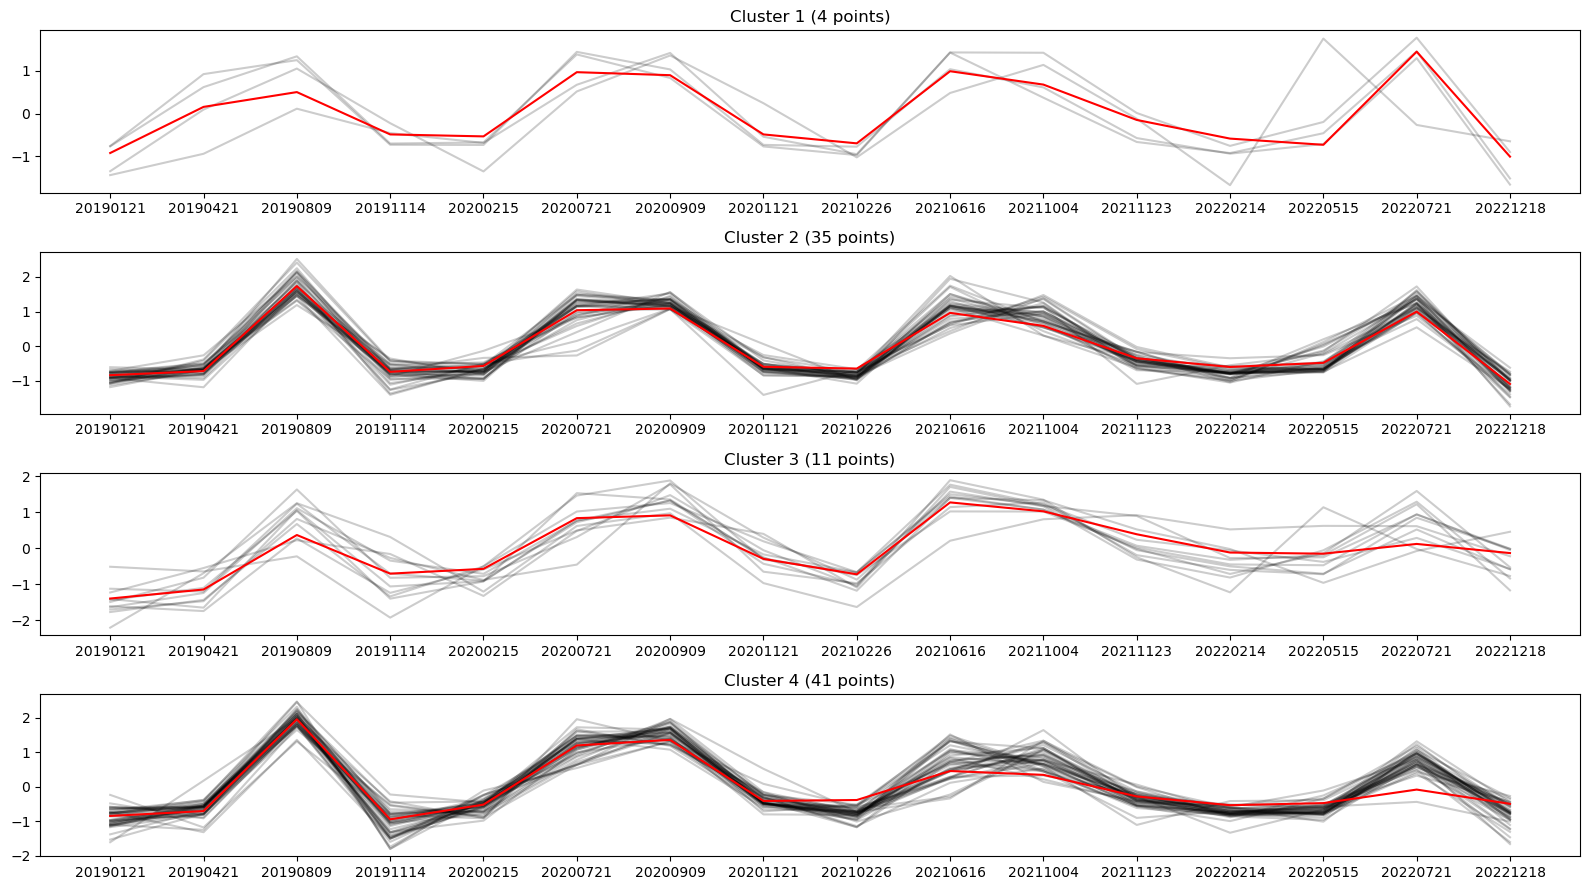

In [47]:
run_model(kmeans_tslearn, "kmeans_tslearn", "NDVI", df_ndvi,{"model__n_clusters": 4})

#### EVI
----
With the EVI, results differ significantly from the previous implementation, as there are two smaller clusters and one big one, as well as the time series look quite differnet per cluster.

Interpretation of the clusters:
- Cluster 1 - clear seasonal trend, very high values and big range - young reed
- Cluster 2 - still very good seasonality although has more noise especially as the years go on the seasonality dissipates - broken reed
- Cluster 3 - very similar to Cluster 1 but with more mild peaks - old reed

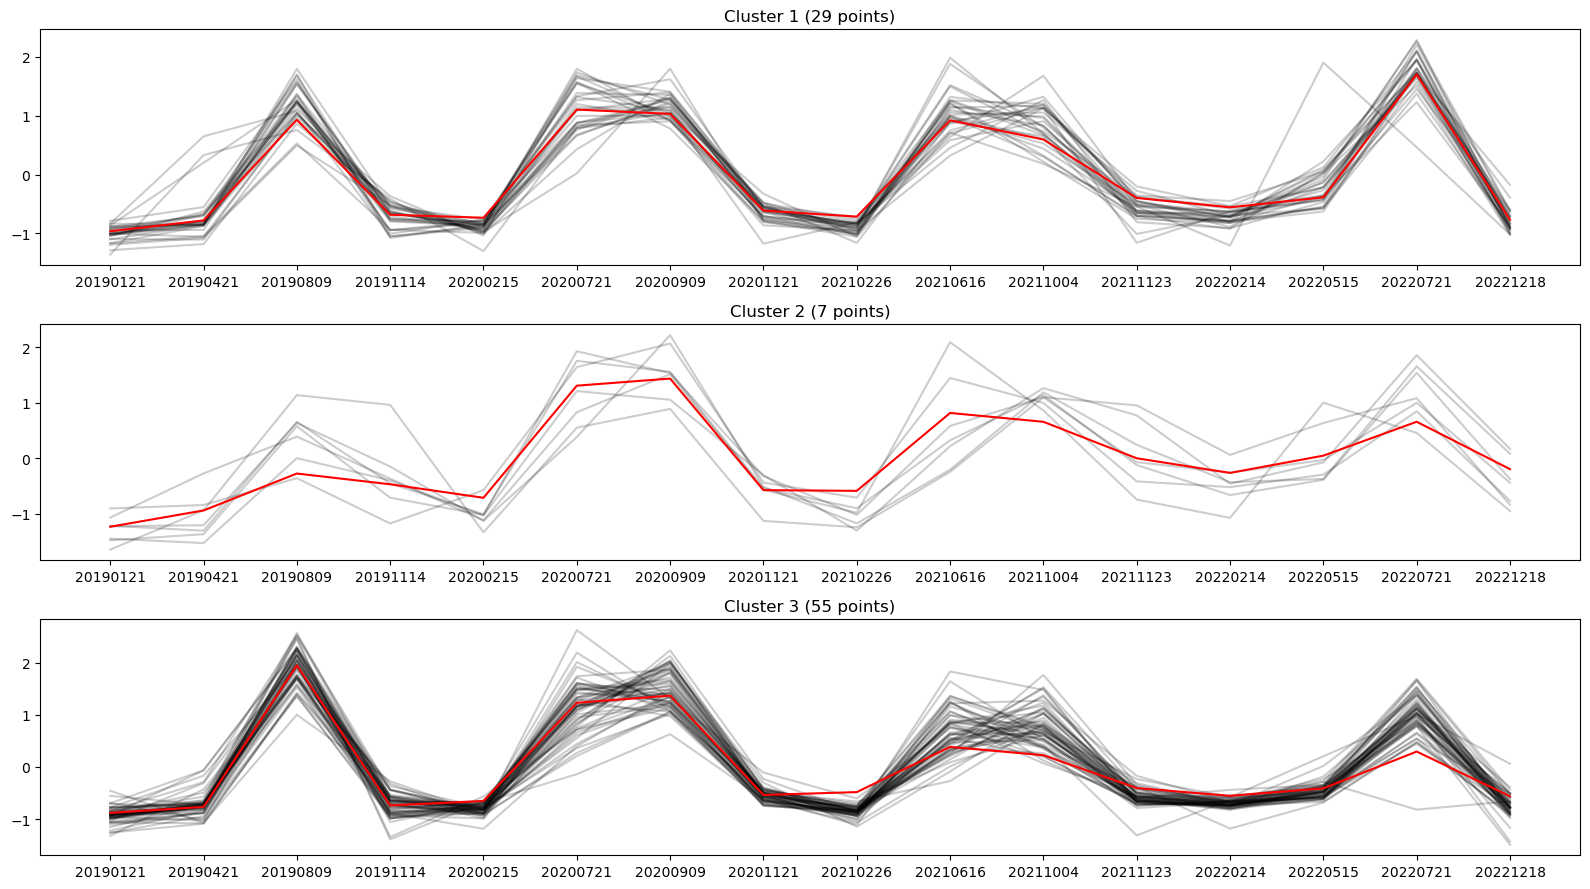

In [64]:
run_model(kmeans_tslearn, "kmeans_tslearn", "EVI", df_evi, {"model__n_clusters": 3})

Interpretation of the clusters:
- Cluster 1 - clear seasonal trend, very high values and big range - young reed
- Cluster 2 - some seasonal pattern, lower values - old reed 
- Cluster 3 - erratic behavior, off-season peaks - broken reed
- Cluster 4 - some seasonal pattern, lower values, very similar to Cluster 2 - old reed 

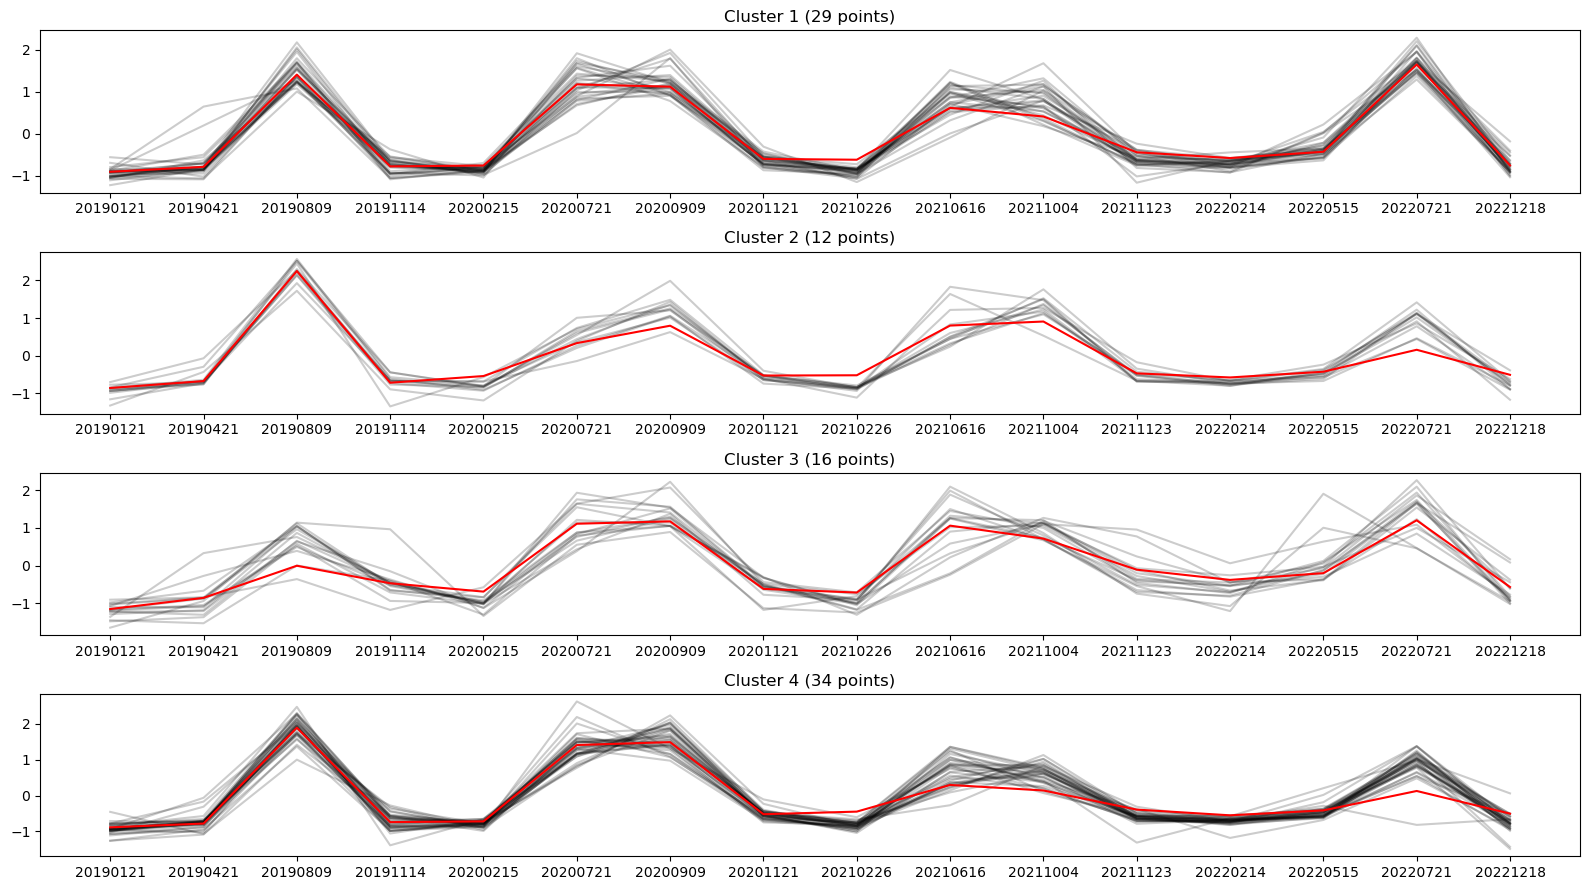

In [49]:
run_model(kmeans_tslearn, "kmeans_tslearn", "EVI", df_evi, {"model__n_clusters": 4})

### DBSCAN
---
DBSCAN was chosen as the last algorithm to experiment with the clustering. The experiments with the application however showed that is not well suited for the use on this data. This is indicated by the fact that in most settings tested a great portion if not the majority of points were deemed as noise (indicated by the label `-1`). Furthermore, for the NDMI and EVI under certain settings all points are classified as noise. Since the algorithm showed to be very unstable given the data under different configurations, and provided no useful results it is not used to evaluate the task. The reason why this algorithm did not fit well in this case might be because the density of the expected clusters will most likely not be similar, since the points were sampled randomly from the whole surface area of the reed belt.

In [50]:
from sklearn.cluster import DBSCAN
dbscan = Pipeline(steps=[
    ('scaler', MinMaxScaler()), 
    ('model', DBSCAN())])
params1 = {"model__min_samples":5, "model__eps": 0.5}
params2 = {"model__min_samples":8, "model__eps": 0.3}

In [51]:
dbscan.set_params(**params1).fit(df_ndmi)
pd.value_counts(dbscan['model'].labels_)

 0    56
-1    30
 1     5
dtype: int64

In [52]:
dbscan.set_params(**params2).fit(df_ndmi)
pd.value_counts(dbscan['model'].labels_)

-1    91
dtype: int64

In [53]:
dbscan.set_params(**params1).fit(df_ndvi)
pd.value_counts(dbscan['model'].labels_)

 0    79
-1    12
dtype: int64

In [54]:
dbscan.set_params(**params2).fit(df_ndvi)
pd.value_counts(dbscan['model'].labels_)

-1    69
 1    14
 0     8
dtype: int64

In [55]:
dbscan.set_params(**params1).fit(df_evi)
pd.value_counts(dbscan['model'].labels_)

 0    80
-1    11
dtype: int64

In [56]:
dbscan.set_params(**params2).fit(df_evi)
pd.value_counts(dbscan['model'].labels_)

-1    47
 0    37
 1     7
dtype: int64

## Results
----
For the scikit learn implementation, four clusters have a smaller inertia for all the indices indicating a better result, which is exactly opposite for the tslearn implementation. However, the silhouette scores are larger when there are fewer clusters, this might be because, the cluster density is uneven. In the end, these metrics are to quantify the performance of the algorithm, but the interpretation of the clusters themselves is of grater value to the experiment than optimizing these metrics. 

In [57]:
pd.DataFrame(metrics).pivot(index=["model_name", "index", "n_clusters"], columns=[], values=["inertia", "silhouette_score"])

inertia  silhouette_score
model_name     index n_clusters                             
kmeans_scikit  NDMI  3           31.209508          0.188631
                     4           28.961944          0.158690
               NDVI  3           21.604553          0.199464
                     4           20.588022          0.135877
               EVI   3           19.498302          0.286354
                     4           16.724700          0.221022
kmeans_tslearn NDMI  3           57.221685          0.129508
                     4           56.297864          0.134289
               NDVI  3           73.876760          0.119175
                     4           74.504936          0.105591
               EVI   3           71.818299          0.183037
                     4           74.763614          0.119583